In [53]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashiqnazir/cbtweets")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cbtweets


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from tqdm.notebook import tqdm, trange
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch import optim
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
sns.set()

In [55]:
os.listdir('/kaggle/input/cbtweets')

['CBTweets.csv']

In [56]:
df = pd.read_csv('/kaggle/input/cbtweets/CBTweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [57]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [59]:
df.apply(pd.isnull).sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [60]:
df.duplicated().sum()

36

In [61]:
df.drop_duplicates(inplace = True)

In [62]:
df.reset_index(drop = True, inplace = True)

In [63]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

In [64]:
le = LabelEncoder()

In [65]:
df['labels'] = le.fit_transform(df['cyberbullying_type'])

In [66]:
df.head()

,tweet_text,cyberbullying_type,labels
0,"In other words #katandandre, your food was cra...",not_cyberbullying,3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,3


In [67]:
for i in range(6):
    print('label', i, ':', le.inverse_transform([i]))

label 0 : ['age']
label 1 : ['ethnicity']
label 2 : ['gender']
label 3 : ['not_cyberbullying']
label 4 : ['other_cyberbullying']
label 5 : ['religion']


In [68]:
torch.manual_seed(0)

In [69]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [70]:
def train_one_epoch(model: nn.Module, train_loader: DataLoader, optimizer: optim):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = nn.NLLLoss()

    for batch in (pbar := tqdm(train_loader, leave = False)):
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        accuracy = 100 * correct / total
        pbar.set_description(f'Train Accuracy = {accuracy:.2f}% | Loss = {loss.item():.3f}')

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = 100 * correct / total
    return avg_loss, avg_accuracy

In [71]:
def evaluate(model: nn.Module, valid_loader: DataLoader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = 0
    loss_fn = nn.NLLLoss()

    with torch.no_grad():
        for batch in (pbar := (tqdm(valid_loader, leave = False))):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
            pbar.set_description(f'Validation Accuracy = {accuracy:.2f} | Validation Loss = {loss.item():.3f}')

    avg_loss = total_loss / len(valid_loader)
    avg_accuracy = 100 * correct / total
    return avg_loss, avg_accuracy

In [119]:
def test(model: nn.Module, test_loader: DataLoader, classes: dict):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm_display_labels = [classes[i] for i in range(len(classes))]

    plt.figure(figsize = (10, 7))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = cm_display_labels, yticklabels = cm_display_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [113]:
def train(model: nn.Module, train_loader: DataLoader, valid_loader: DataLoader, n_epochs: int = 1, learning_rate: float = 1e-4):
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        pbar.set_description(f'Train Accuracy = {train_acc:.2f} | Train Loss = {train_loss:.3f}')
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        val_loss, val_acc = evaluate(model, valid_loader)
        pbar.set_description(f'Validation Accuracy = {val_acc:.2f} | Validation Loss = {val_loss:.3f}')
        history['val_loss'].append(val_loss), history['val_acc'].append(val_acc)

    plot_training_curves(history)

    return history

In [74]:
def plot_training_curves(results):
    epochs_range = range(1, len(results['train_loss']) + 1)
    plt.figure(figsize = (14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, results['train_loss'], label = 'Train Loss')
    plt.plot(epochs_range, results['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.xticks(epochs_range)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, results['train_acc'], label = 'Train Accuracy')
    plt.plot(epochs_range, results['val_acc'], label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xticks(epochs_range)
    plt.yticks(range(0, 101, 10))
    plt.legend()

    plt.tight_layout()
    plt.show()

In [75]:
def display_predictions(model: nn.Module, test_loader: DataLoader, tokenizer, classes: dict, num_samples: int = 10):
    model.eval()
    samples_shown = 0
    max_seq_len = test_loader.dataset[0]['input_ids'].shape[0]

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)

            for i in range(len(inputs)):
                if samples_shown >= num_samples:
                    return

                input_text = tokenizer.decode(inputs[i], skip_special_tokens = True)
                probs = nn.functional.softmax(outputs[i], dim=0)

                true_labels = classes[labels[i].item()]
                pred_probs = {classes[j]: probs[j].item() for j in range(len(classes))}

                print(f'Sample {samples_shown + 1}')
                print(f'Text: {input_text}')
                print(f'True Label: {true_labels}')
                print(f'Predicted Probabilities:\n{pd.Series(pred_probs).to_string()}')
                print('=' * 80)

                samples_shown += 1

In [76]:
classes = {0: 'age', 1: 'ethnicity', 2: 'gender', 3: 'not_cyberbulling', 4: 'other_cyberbulling', 5: 'religion'}
num_classes = len(classes)
print(f'Number of classes: {num_classes}')

Number of classes: 6


In [77]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet_text'], df['labels'], test_size = 0.4, 
                                                   random_state = 101, stratify = df['labels'])

In [78]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.4, random_state = 101,
                                                    stratify = y_test)

In [79]:
print(f'Train set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')
print(f'Validation set size: {len(X_valid)}')

Train set size: 28593
Test set size: 11437
Validation set size: 7626


In [80]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
X_valid.reset_index(drop = True, inplace = True)

In [81]:
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
y_valid.reset_index(drop = True, inplace = True)

In [82]:
text = X_train[0]
label = y_train[0]
print(classes[label], ':', text)

age : Insanity is waking up and finding out that the girl who bullied you in junior high forgot big reasons why you were friends in elementary.


In [83]:
text = X_train[4]
label = y_train[4]
print(classes[label], ':', text)

not_cyberbulling : Confessions of a Cheating Teacher: “It’s easy to lose your moral compass when you’re being bullied”: http://t.co/MwFdf7A


In [84]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_len = 48
vocab_size = tokenizer.vocab_size

In [85]:
def preprocess(texts, labels, max_length = max_len):
    inputs = tokenizer(texts, padding = 'max_length', truncation = True, max_length = max_length, return_tensors = 'pt')
    inputs['labels'] = torch.tensor(labels)
    return inputs

In [86]:
train_inputs = preprocess(X_train.tolist(), y_train.tolist())
test_inputs = preprocess(X_test.tolist(), y_test.tolist())
valid_inputs = preprocess(X_valid.tolist(), y_valid.tolist())

In [87]:
class MyDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.inputs.items()}
        return item

In [88]:
train_dataset = MyDataset(train_inputs)
test_dataset = MyDataset(test_inputs)
valid_dataset = MyDataset(valid_inputs)

In [89]:
batch_size = 64

In [90]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)

In [107]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout: float):
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def calculate_score(self, queries: Tensor, keys: Tensor) -> Tensor:
        return torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(queries.shape[-1])

    def forward(self, queries: Tensor, keys: Tensor, values: Tensor, batch_size: int, num_heads: int, seq_length: int, dim_k: int) -> Tensor:
        keys = keys.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, dim_k)
        queries = queries.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, dim_k)
        values = values.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, dim_k)

        score = self.calculate_score(queries, keys)
        softmax_weights = F.softmax(score, dim=2)

        out = torch.bmm(self.dropout(softmax_weights), values)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, num_heads * dim_k)

        return out

In [105]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int = 8, dropout: float = 0.1):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.to_keys = nn.Linear(embed_dim, embed_dim * num_heads, bias = False)
        self.to_queries = nn.Linear(embed_dim, embed_dim * num_heads, bias = False)
        self.to_values = nn.Linear(embed_dim, embed_dim * num_heads, bias = False)
        self.unify_heads = nn.Linear(embed_dim * num_heads, embed_dim)

        self.attention = DotProductAttention(dropout)

    def forward(self, x: Tensor) -> Tensor:
        batch_size, seq_length, embed_dim = x.size()
        num_heads = self.num_heads

        queries = self.to_queries(x).view(batch_size, seq_length, num_heads, embed_dim)
        keys = self.to_keys(x).view(batch_size, seq_length, num_heads, embed_dim)
        values = self.to_values(x).view(batch_size, seq_length, num_heads, embed_dim)

        out = self.attention(queries, keys, values, batch_size, num_heads, seq_length, embed_dim)

        return self.unify_heads(out)

In [93]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_dim, num_heads = num_heads)

        self.norm_1 = nn.LayerNorm(embed_dim)
        self.norm_2 = nn.LayerNorm(embed_dim)

        hidden_size = 2 * embed_dim
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_dim)
        )

    def forward(self, x: Tensor) -> Tensor:
        attended = self.attention(x)
        x = self.norm_1(attended + x)

        feedforward = self.mlp(x)
        x = self.norm_2(feedforward + x)

        return x

In [94]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout = 0.1, max_len = 512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p = dropout)

        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-np.log(10000.0) / emb_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [97]:
class Transformer(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, depth: int, seq_length: int, num_tokens, num_classes: int):
        super(Transformer, self).__init__()

        self.embed_dim = embed_dim
        self.num_tokens = num_tokens
        self.token_embedding = nn.Embedding(num_tokens, embed_dim)
        self.pos_enc = PositionalEncoding(embed_dim)

        transformer_blocks = [TransformerBlock(embed_dim = embed_dim, num_heads = num_heads) for _ in range(depth)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = self.token_embedding(x) * np.sqrt(self.embed_dim)
        x = self.pos_enc(x)
        x = self.transformer_blocks(x)

        sequence_avg = x.mean(dim=1)
        x = self.classification_head(sequence_avg)
        logprobs = F.log_softmax(x, dim=1)
        return logprobs

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

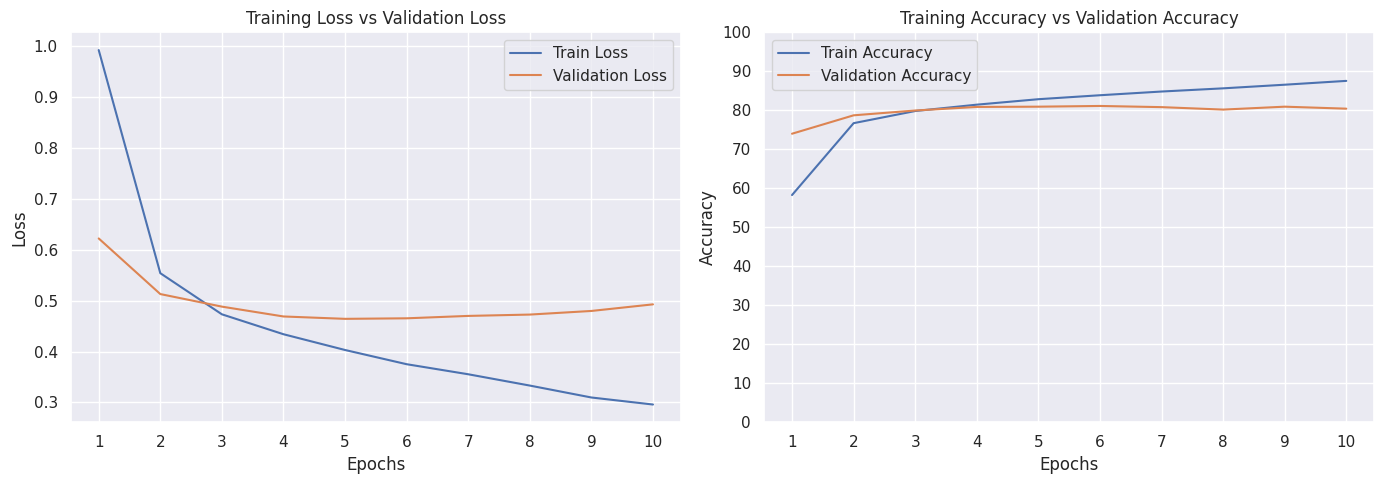

In [114]:
model = Transformer(128, 8, 3, max_len, vocab_size, num_classes).to(device)
results = train(model, train_loader = train_loader, valid_loader = valid_loader, n_epochs = 10)

In [117]:
test_loss = 0 
correct = 0
total = 0
loss_fn = nn.NLLLoss()
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        accuracy = 100 * correct / total
avg_loss = test_loss / len(test_loader)
avg_accuracy = 100 * correct / total
print(f'Test Loss: {avg_loss:.3f} | Test Accuracy: {avg_accuracy:.2f}')

Test Loss: 0.497 | Test Accuracy: 80.57


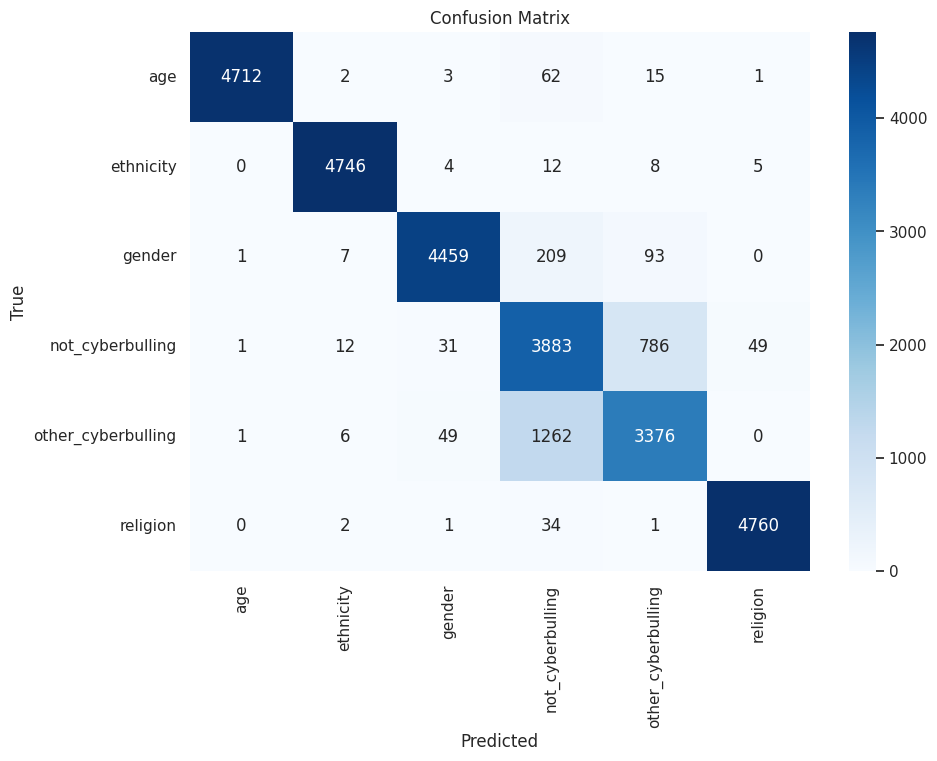

In [120]:
test(model, train_loader, classes)

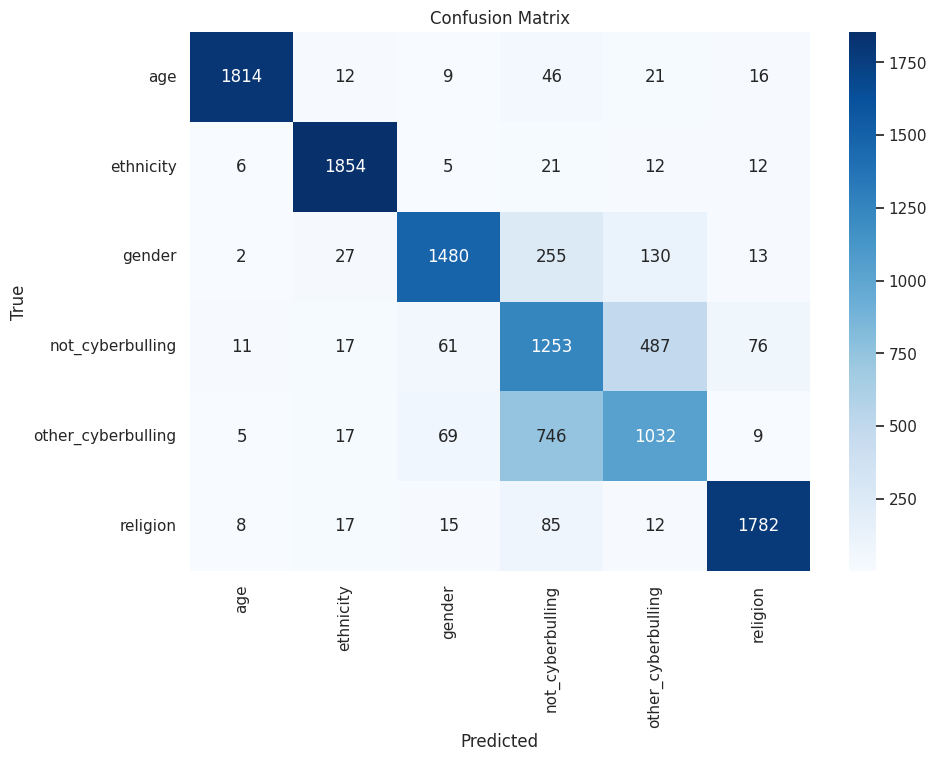

In [121]:
test(model, test_loader, classes)